In [446]:
import pandas as pd
import numpy as np
import os
import re
from quasinet.qnet import Qnet, qdistance, membership_degree, export_qnet_tree,load_qnet, qdistance_matrix, save_qnet
from quasinet.qsampling import qsample, targeted_qsample
import subprocess
EMBED='/home/ishanu/Dropbox/ZED/Research/data_smashing_/bin/embed '
import seaborn as sns
import random
from tqdm import tqdm
from pqdm.processes import pqdm                                                                     
from sklearn import metrics
import pylab as plt
from sklearn.decomposition import PCA
from scipy.stats import entropy

In [54]:
OUTPUTDIR='./bondcourtdata/results/'

+ Columns with atleast one non-nan  45
+ Max alphabet 4
mean response time:  8.500173076923078 s
mean number of responses:  29.0


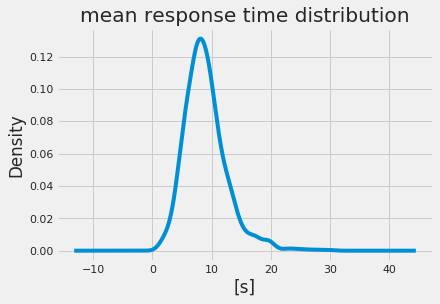

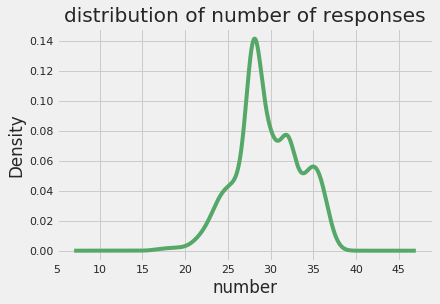

In [286]:
# read data
sns.set()
plt.style.use('fivethirtyeight')
data=pd.read_csv('./bondcourtdata/CCHHS_SUD_details.csv',index_col=0).dropna(axis=1,how='all')\
                .fillna(1000).astype(int).replace(1000,'')
COLS=data.columns
IDS=data.index
# durations record
dur=pd.read_csv('./bondcourtdata/CCHHS_SUD_durations.csv',index_col=0).dropna(axis=1,how='all')
ax=dur.mean(axis=1).plot.kde()
plt.gca().set_xlabel('[s]')
ax.set_title('mean response time distribution');
print('+ Columns with atleast one non-nan ',len(COLS))
print('+ Max alphabet',data.max(axis=1).max())
plt.figure()
ax=dur.isnull().sum(axis=1).plot.kde(color='g')
ax.set_title('distribution of number of responses');
ax.set_xlabel('number');
print('mean response time: ',dur.mean(axis=1).median(),'s')
print('mean number of responses: ',dur.isnull().sum(axis=1).median())

In [56]:
# get qnet formatted data
X = data.values.astype(str)
X

array([['1', '1', '', ..., '0', '0', '0'],
       ['', '2', '', ..., '0', '0', '0'],
       ['', '1', '', ..., '0', '0', '0'],
       ...,
       ['', '1', '', ..., '0', '0', '0'],
       ['', '2', '', ..., '0', '0', '0'],
       ['', '2', '', ..., '0', '0', '0']], dtype='<U1')

In [63]:
qnet = Qnet(n_jobs=12,feature_names=COLS,alpha=.2).fit(X)

In [64]:
if REGEN:
    save_qnet(qnet,OUTPUTDIR+'qnet.joblib')
else:
    qnet=load_qnet(OUTPUTDIR+'qnet.joblib')

In [66]:
if REGEN:
    for idx, feature_name in enumerate(qnet.feature_names):
                export_qnet_tree(qnet, idx,
                os.path.join(OUTPUTDIR, '{}.dot'.format(feature_name)),
                outformat='graphviz', detailed_output=False)

In [222]:
#n=50
Nsteps=1000
index1=len(X)
X_=X

In [223]:
# generate distanec matrix
if REGEN:
    H=qdistance_matrix(X_,X_, qnet, qnet)
    pd.DataFrame(H).to_csv(OUTPUTDIR+'HMAT.csv',index=None,header=None,sep=' ')
    H.shape

(1250, 1250)

In [224]:
# calculate sippl embedding
PREF=OUTPUTDIR
FILE='HMAT.csv'
DATAFILE=PREF+FILE#'data_'
EFILE=PREF+'_Eb1_'
DFILE=PREF+'_Db1_'
PCAEFILE=PREF+'_PEb1_'

In [225]:
if REGEN:
    STR=EMBED+' -f '+DATAFILE+' -E '+EFILE+' -D '+DFILE
    subprocess.call(STR,shell=True);

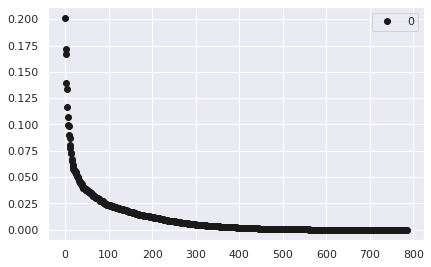

In [226]:
# plot dimensional error
pd.read_csv(DFILE,sep=' ',header=None).transpose().plot(style='ko')

In [227]:
# get embedding matrix
E=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
E.columns=['x'+str(i) for i in E.columns]
E.to_csv(PREF+'Eb1.csv')

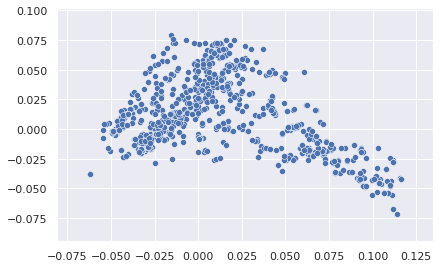

In [229]:
Ef=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
Ef.columns=['x'+str(i) for i in Ef.columns]
xf=Ef#.assign(IF=dx.ido)

pca = PCA(n_components=2).fit(xf)
ef=pca.fit_transform(xf)

pd.DataFrame(ef).to_csv(PCAEFILE,header=None,index=None)

sns.scatterplot(x=ef[:,0],y=ef[:,1]);
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

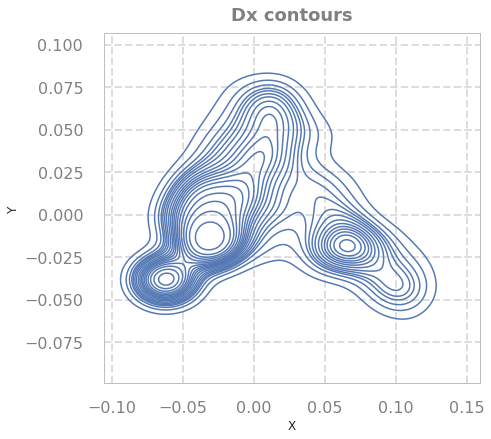

In [261]:
def varname(x):
    if x:
        return '~False'
    return 'True'
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

pf=pd.DataFrame(ef,columns=['X','Y'])#.assign(ido=LABEL)
#pf['dx']=(pf.ido==1)
#pf['dx']=[varname(x) for x in pf.dx]
ax=sns.kdeplot(x='X',y='Y',fill=False,data=pf,alpha=.95,lw=2,levels=20,thresh=.05,palette=['.5','r'],fontsize=16)

ax.set_title('Dx contours',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig(OUTPUTDIR+'dxcontour'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [231]:
# the null response
s_null=['']*len(X[0])
D_null=qnet.predict_distributions(s_null)

In [232]:
def getMaskedSample(s,cols,mutable_vars,
                    mask_prob=0.5,
                    allow_all_mutable=False):
    '''
    Get random masked sample, with mask_prob fraction masked
    '''
    MUTABLE=pd.DataFrame(np.zeros(len(cols)),index=cols).transpose()
    WITHVAL=[x for x in cols[np.where(s)[0]] if x in mutable_vars ]
    MASKrand=[x for x in WITHVAL if random.random() > mask_prob ]
    for m in MASKrand:
        MUTABLE[m]=1.0
            
    mutable_x=MUTABLE.values[0]
    base_frequency=mutable_x/mutable_x.sum()
    
    s1=s.copy()
    for i in range(len(base_frequency)):
        if base_frequency[i]>0.0001:
            s1[i]=''
            
    s_rand=np.copy(s)
    rnd_match_prob=[]        
    max_match_prob=[]        
    D=qnet.predict_distributions(s)
    for i in MASKrand:
        s_rand[np.where(
            cols==i)[0][0]]=choose_one(
                D_null[np.where(cols==i)[0][0]].keys())
        rnd_match_prob=np.append(rnd_match_prob,1/len(
            D_null[np.where(cols==i)[0][0]].keys()))
        max_match_prob=np.append(
            max_match_prob,np.max(
                list(D[np.where(
                    cols==i)[0][0]].values())))
        
    if allow_all_mutable:
        for m in mutable_vars:
            MUTABLE[m]=1.0
        mutable_x=MUTABLE.values[0]
        base_frequency=mutable_x/mutable_x.sum()

    return s1,base_frequency,MASKrand,np.where(
        base_frequency)[0],np.mean(rnd_match_prob),np.mean(max_match_prob),s_rand

def choose_one(X):
    X=list(X)
    if len(X)>0:
        return X[np.random.randint(len(X))]
    return None

samples=None
def getRecon(index,MEAN=True):
    s=samples[index]
    
    s1,bp,mask_,maskindex,rmatch_u,rmatch,s_rand=getMaskedSample(s,cols,
                                                                     mutable_vars,
                                                                     mask_prob=MASKPROB)
    qs=qsample(s1,qnet,Nsteps,bp)
    recondf=pd.DataFrame([s,qs,s_rand],columns=cols,index=['s','q','r'])[mask_].transpose()
    recondf=recondf.replace('',np.nan).dropna(axis=0).astype(float)
    recondf['delta']=recondf.s-recondf.q
    if MEAN:
        return recondf.delta.mean()
    return recondf

In [290]:
# Reconstruction parameters
cols=qnet.feature_names
mutable_vars=cols
MASKPROB=0.10 #on avearge this means we mask all but 3 responses
Nsteps=120

In [291]:
if REGEN:
    samples=X_
    Recon=pqdm(range(len(X_)), getRecon, n_jobs=12)                                                              
    DF=pd.DataFrame(Recon,columns=['recon'])
    DF
    DF.to_csv(PREF+'Recon10.csv')
DF=pd.read_csv(PREF+'Recon10.csv',index_col=0)

mean positive dissonance:  0.41117292560165847 mean negative dissonance:  -0.21904200628615597


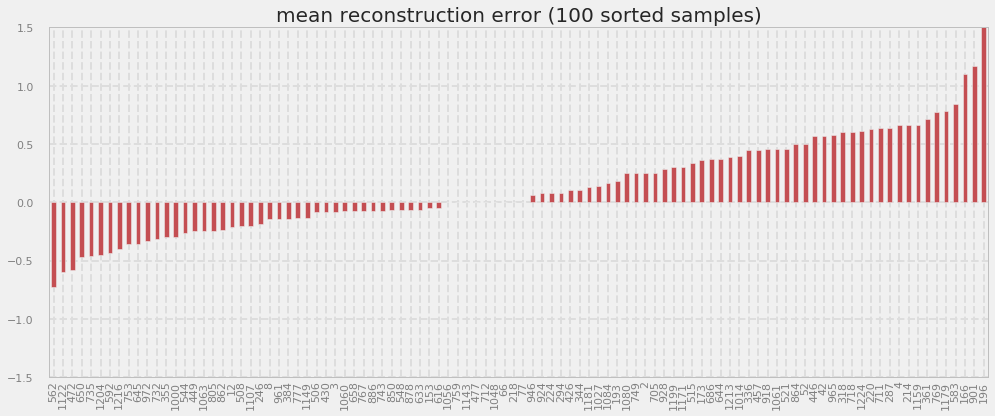

In [395]:
plt.figure(figsize=[15,6])
sns.set()

plt.style.use('fivethirtyeight')
print('mean positive dissonance: ',DF[DF.recon>0].recon.mean(),
      'mean negative dissonance: ',DF[DF.recon<0].recon.mean())
#plt.subplot(2,1,1)
#plt.subplots_adjust(hspace=.5)
#DF.iloc[:len(index1),:].recon.plot(kind='bar',color='r')
DF.sample(100).recon.sort_values().plot(kind='bar',color='r')
plt.gca().set_xlabel('')
ax=plt.gca()
ax.set_title('mean reconstruction error (100 sorted samples)',fontsize=20);
#ax.legend(['error'],fontsize=18)
ax.set_ylim(-1.5,1.5)

#plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
#plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black


plt.savefig(PREF+'recosntruction'+'.png',dpi=600,bbox_inches='tight',transparent=True)

## conclusions
+ we achieve small reconstruction error with a very few items revealed (2.5% or ~3 of the actual responses)
+ positive error (mean: 0.40) is more likely than negative (mean: -0.22, i.e. since pos => s>q, the actual responses tend to be higher magnitude compred to what is estimated by the model. So samples are over-diagnosing severity

In [293]:
def getDissonance(sample_index,index=None,MISSING_VAL=np.nan):                                  
    '''                                                                                               
    Dissonnace vector                                                                                                   
    '''  
    if isinstance(sample_index, int):
        s=samples[sample_index]                                                                           
    else:
        s=sample_index
    if index is None:                                                                                 
        index=range(len(s))                                                                           
                                                                                                      
    Ds=qnet.predict_distributions(s)                                                                  
                                                                                                      
    diss=np.ones(len(Ds))*MISSING_VAL                                                                 
    for i in index:                                                                                   
        if s[i] != '':                                                                                
            if s[i] in Ds[i].keys():                                                                  
                diss[i]=1-Ds[i][s[i]]/np.max(                                                         
                    list(Ds[i].values()))                                                             
            else:                                                                                     
                diss[i]=1.0                                                                           
                                                                                                      
    return diss                                                                        

In [294]:
samples=X
from pqdm.processes import pqdm                                                                     
Diss=pqdm(range(len(X)), getDissonance, n_jobs=12)                                                              
Diss=pd.DataFrame(Diss)

In [329]:
Diss.columns=COLS

In [330]:
diss_array=Diss.values.flatten()
duration_array=dur.values.flatten()
dissonance_duration=pd.DataFrame([diss_array,duration_array],index=['dissonance','duration']).transpose().dropna()

In [399]:
dd=dissonance_duration[(dissonance_duration.duration<25) & (dissonance_duration.dissonance>0)]
print('Correlation between mean dissonance and duration')
display(dd.corr())
dd.corr().to_csv('corr_mdiss_dur.csv')



Correlation between mean dissonance and duration


,dissonance,duration
dissonance,1.000000,0.099331
duration,0.099331,1.000000


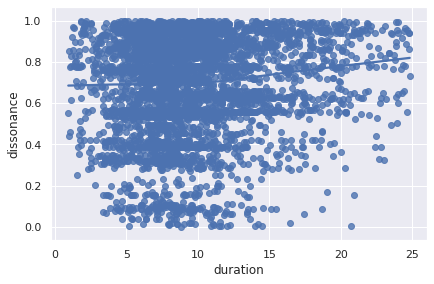

In [332]:
#dissonance_duration.plot.scatter(x='duration',y='dissonance')
ax=sns.regplot(x='duration',y='dissonance',data=dd,lowess=True)

In [449]:
# this is not correct
# we need to generate random responses using base frequency
s_null=['']*len(X[0])
D_null=qnet.predict_distributions(s_null)
D_rnd=[]
nullbp=[]
for i in range(len(X[0])):
    u,c=np.unique(X[:][i], return_counts=True)
    c=c/c.sum()
    D_rnd=np.append(D_rnd,dict(zip(u,c)))
    nullbp=np.append(nullbp,entropy(c,base=len(c)))

nullbp=nullbp/np.sum(nullbp)
def generateNullSample(D):
    choice_=[]
    for i in range(len(D)):
        keys=list(D[i].keys())
        last_=0
        rkey=np.random.random()
        for k in keys:
            last_=D[i][k]+last_
            if rkey <= last_:
                break
        choice_=np.append(choice_,k)
    return choice_
            

len(generateNullSample(D_rnd))

45

In [334]:
# generate random responses
Xrand=[generateNullSample(D_rnd) for i in range(1300)]

In [335]:
# compute dissonance for random responses
samples=Xrand
from pqdm.processes import pqdm                                                                     
Dissrand=pqdm(range(len(Xrand)), getDissonance, n_jobs=12)                                                              
Dissrand=pd.DataFrame(Dissrand)

In [343]:
Dissrand.columns=COLS

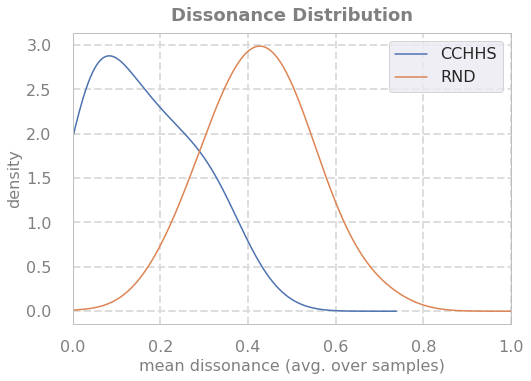

In [344]:
fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()


#Dissj.mean(axis=1).plot.kde(bw_method=0.25,lw=3,label='JAIL')
#Diss.mean(axis=1).plot.kde(ax=ax,bw_method=0.25,lw=3,label='SA')
DS=pd.DataFrame(Diss.mean(axis=1),columns=['CCHHS']).join(
    pd.DataFrame(Dissrand.mean(axis=1),columns=['RND']))

DSTD=pd.DataFrame(Diss.std(axis=1),columns=['CCHHS']).join(
    pd.DataFrame(Dissrand.std(axis=1),columns=['RND']))

DS=DS.join(DSTD,rsuffix='_std').dropna()

#DS=DS.assign(delta=DS.SA-DS.JAIL)


ax=DS.CCHHS.plot.kde(bw_method=.5)
#DS.JAIL.plot.kde(ax=ax,bw_method=.2)
DS.RND.plot.kde(ax=ax,bw_method=.5)
ax.set_xlim(0,1)


ax.set_title('Dissonance Distribution',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#plt.gca().set_xlim(-.1,.4)
ax.set_ylabel('density',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance (avg. over samples)',fontsize=16,color='.5')
ax.legend(fontsize=16)

plt.savefig(PREF+'dissonance_dist'+'.png',dpi=600,bbox_inches='tight',transparent=True)

Thershold (90%):  0.2726682903261337
Thershold (95%):  0.2295430290074813


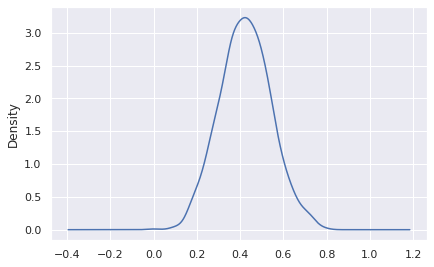

In [359]:
# determine threshold
Dissrand.mean(axis=1).plot.kde()
mRND=Dissrand.mean(axis=1).mean()
sRND=Dissrand.mean(axis=1).std(ddof=1)
from scipy import stats

# alpha to critical
alpha_p1 = 0.1
alpha_p05 = 0.05
n_sided = 1 # 2-sided test
z_crit = stats.norm.ppf(1-alpha_p1/n_sided)
threshold_p1=(-z_crit*sRND)+mRND

z_crit = stats.norm.ppf(1-alpha_p05/n_sided)
threshold_p05=(-z_crit*sRND)+mRND


print('Thershold (90%): ',threshold_p1)
print('Thershold (95%): ',threshold_p05)


In [360]:
# the "lying" samples at 5 and 10% significance
mDiss=Diss.mean(axis=1).sort_values(ascending=False)
print('95% ',mDiss[mDiss>threshold_p05])
print('90% ',mDiss[mDiss>threshold_p1])

95%  900     0.491918
1226    0.484263
346     0.469582
275     0.465557
243     0.465557
          ...   
971     0.231941
607     0.231234
914     0.230886
332     0.230575
977     0.230355
Length: 378, dtype: float64
90%  900     0.491918
1226    0.484263
346     0.469582
275     0.465557
243     0.465557
          ...   
1242    0.275855
23      0.274980
1050    0.273828
662     0.273711
1231    0.273422
Length: 267, dtype: float64


In [403]:
DS=pd.DataFrame(Diss.mean(axis=0),columns=['CCHHS']).join(
    pd.DataFrame(Dissrand.mean(axis=0),columns=['RND']))
DSTD=pd.DataFrame(Diss.std(axis=0),columns=['CCHHS']).join(
    pd.DataFrame(Dissrand.std(axis=0),columns=['RND']))
DSn=pd.DataFrame(Diss.count(axis=0),columns=['CCHHS']).join(
    pd.DataFrame(Dissrand.count(axis=0),columns=['RND']))


DSs=DS.join(DSTD,rsuffix='_std').join(DSn,rsuffix='_n').dropna()
DSs.CCHHS_std=DSs.CCHHS_std/np.sqrt(DSs.CCHHS_n)
DSs.RND_std=DSs.RND_std/np.sqrt(DSs.RND_n)
DSs=DSs.assign(delta=(DSs.RND-DSs.CCHHS))
DSs=DSs.sort_values('delta',ascending=True)
DSs.head()

,CCHHS,RND,CCHHS_std,RND_std,CCHHS_n,RND_n,delta
6421,0.323845,0.227591,0.016714,0.018195,456,494,-0.096255
6399,0.238002,0.179019,0.019852,0.017465,346,479,-0.058983
6319,0.230471,0.205185,0.011154,0.017784,1250,504,-0.025286
6427,0.474235,0.498199,0.029623,0.023840,189,357,0.023964
6409,0.235135,0.269454,0.011197,0.021676,799,364,0.034320


In [400]:
DSs.index.size

43

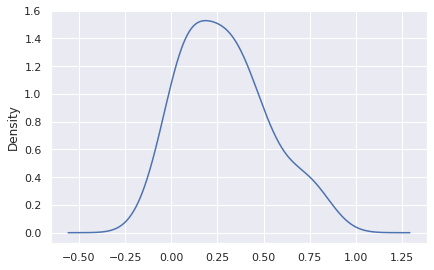

In [362]:
DSs.delta.plot.kde()

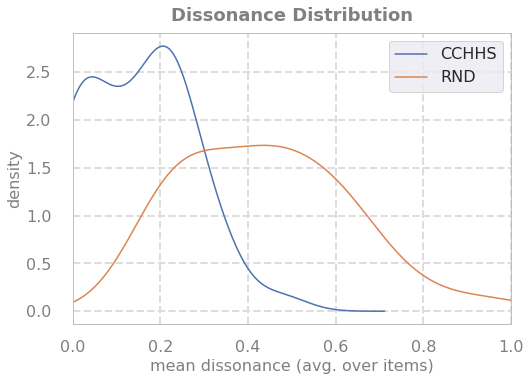

In [364]:
fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()

ax=DSs.CCHHS.plot.kde(bw_method=.5)

DSs.RND.plot.kde(ax=ax,bw_method=.5)
ax.set_xlim(0,1)

ax.set_title('Dissonance Distribution',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#plt.gca().set_xlim(-.1,.4)
ax.set_ylabel('density',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance (avg. over items)',fontsize=16,color='.5')
ax.legend(fontsize=16)

plt.savefig(PREF+'dissonance_dist_items_nonnan'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [ ]:
# identify the items with random-like dissonance


##  Note:  that ALT=False mostly for recon > 0, ie when the samples are "over-diagnosing"

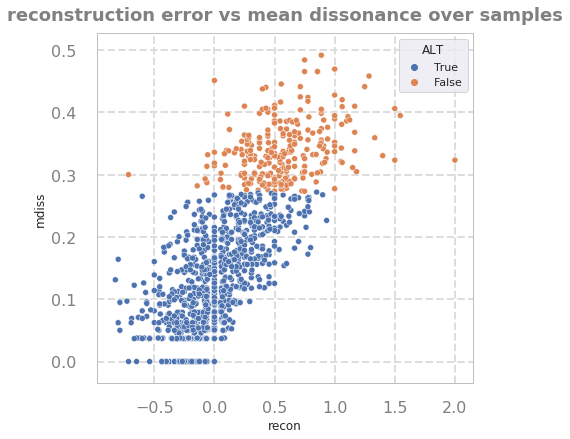

In [390]:
cf=DF.join(pd.DataFrame(Diss.mean(axis=1),columns=['mdiss']))
#cf.recon=cf.recon.abs()
cf['ALT']=(cf.mdiss>threshold_p1)
cf['ALT']=[varname(x) for x in cf.ALT]
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

sns.scatterplot(x='recon',y='mdiss',data=cf,hue='ALT');

ax.set_title('reconstruction error vs mean dissonance over samples',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig(OUTPUTDIR+'scatter_recon_mdiss'+'.png',dpi=600,bbox_inches='tight',transparent=True)

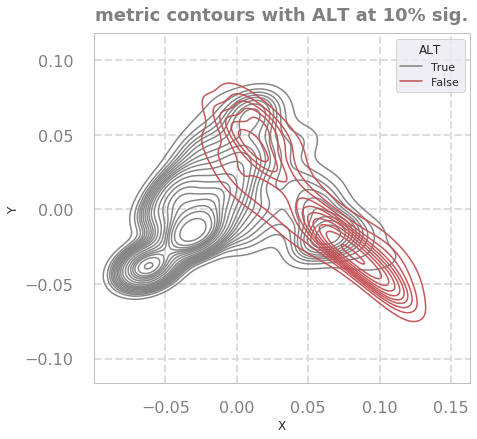

In [385]:
def varname(x):
    if x:
        return 'False'
    return 'True'
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

pf=pd.DataFrame(ef,columns=['X','Y']).assign(ido=cf.mdiss)
pf['ALT']=(pf.ido>threshold_p1)
pf['ALT']=[varname(x) for x in pf['ALT']]
ax=sns.kdeplot(x='X',y='Y',fill=False,data=pf,alpha=.95,lw=2,levels=20,thresh=.05,hue='ALT',palette=['.5','r'],fontsize=16)

ax.set_title('metric contours with ALT at 10% sig.',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig(OUTPUTDIR+'dxcontour_diss_p10'+'.png',dpi=600,bbox_inches='tight',transparent=True)

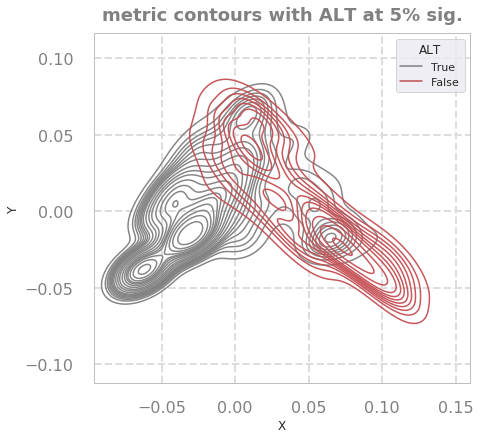

In [384]:
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

pf=pd.DataFrame(ef,columns=['X','Y']).assign(ido=cf.mdiss)
pf['ALT']=(pf.ido>threshold_p05)
pf['ALT']=[varname(x) for x in pf['ALT']]
ax=sns.kdeplot(x='X',y='Y',fill=False,data=pf,alpha=.95,lw=2,levels=20,thresh=.05,hue='ALT',palette=['.5','r'],fontsize=16)

ax.set_title('metric contours with ALT at 5% sig.',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig(OUTPUTDIR+'dxcontour_diss_p05'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [401]:
dd=dissonance_duration[(dissonance_duration.duration<25) & (dissonance_duration.dissonance>0)]
print('Correlation between mean dissonance and duration')
display(dd.corr())
dd.corr().to_csv('corr_mdiss_dur.csv')



Correlation between mean dissonance and duration


,dissonance,duration
dissonance,1.000000,0.099331
duration,0.099331,1.000000


In [442]:
nH=5
print('Item Indices getting dissonance >= random:\n ',DSs.head(nH).index.values)
DissH=Diss[DSs.head(nH).index]
diss_arrayH=DissH.values.flatten()
duration_arrayH=dur[DSs.head().index].values.flatten()
ddH=pd.DataFrame([diss_arrayH,duration_arrayH],index=['dissonance','duration']).transpose().dropna()
ddH=ddH[(ddH.dissonance>0) & (ddH.duration<40)]
print('\ncorrelation:')
display(ddH.corr())


Item Indices getting dissonance >= random:
  ['6421' '6399' '6319' '6427' '6409']

correlation:


,dissonance,duration
dissonance,1.000000,0.157934
duration,0.157934,1.000000


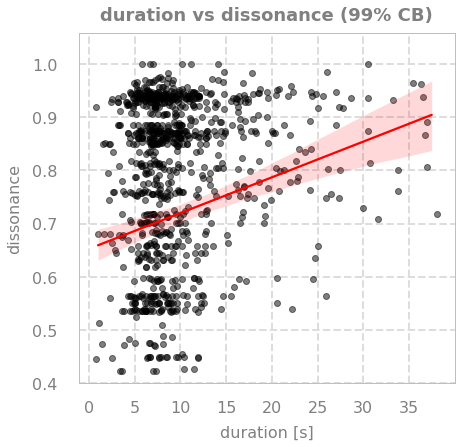

In [443]:
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()
ax=sns.regplot(x='duration',y='dissonance',data=ddH,lowess=False,order=1,x_jitter=1,ci=99,
                 scatter_kws={"color": "black",'alpha':.5}, line_kws={"color": "red"})
ax.set_ylim(.4,None)

ax.set_title('duration vs dissonance (99% CB)',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
ax.set_ylabel('dissonance',fontsize=16,color='.5',labelpad=10)
ax.set_xlabel('duration [s]',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig(OUTPUTDIR+'durvsdiss'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [444]:
# Q-correction via Q-sampling

In [466]:
Nsteps=20
Xc=[]
for s in X:
    Xc=np.append(Xc,qsample(s,qnet,Nsteps,nullbp))
Xc=Xc.reshape(len(Xc)//45,45)

In [467]:
# compute dissonance for random responses
samples=Xc
from pqdm.processes import pqdm                                                                     
DissC=pqdm(range(len(Xc)), getDissonance, n_jobs=12)                                                              
DissC=pd.DataFrame(DissC)

In [468]:
DissC

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.000000,0.578283,0.000000,0.000000,0.0,NaN,0.521561,0.0,0.0,0.0
1,0.0,0.580859,0.0,0.895205,0.985399,0.984701,0.980731,0.000000,NaN,0.000000,...,0.000000,0.600184,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.960564,0.000000,0.242944,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,0.763540,0.000000,0.0,0.0,0.0
3,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,...,0.000000,0.770290,0.000000,0.000000,0.0,0.000000,NaN,0.0,0.0,0.0
4,NaN,0.625630,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,...,NaN,0.220377,NaN,0.995372,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0.0,0.000000,NaN,0.000000,0.966605,0.994512,0.000000,NaN,NaN,0.000000,...,0.000000,0.751323,NaN,NaN,0.0,0.000000,NaN,0.0,0.0,0.0
1246,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.952811,0.378678,0.0,0.000000,...,0.000000,0.000000,0.515309,0.000000,0.0,0.783379,NaN,0.0,0.0,0.0
1247,NaN,0.642888,0.0,0.000000,0.000000,0.946927,0.000000,NaN,0.0,NaN,...,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.919414,0.0,0.0,0.0
1248,NaN,0.553970,NaN,0.950937,0.000000,0.924592,0.940435,NaN,NaN,0.482093,...,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.0,0.0,0.0


In [469]:
DissC.columns=COLS

In [471]:
CORR=True

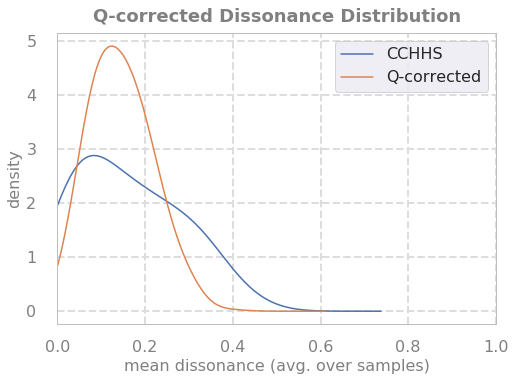

In [470]:
fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()


#Dissj.mean(axis=1).plot.kde(bw_method=0.25,lw=3,label='JAIL')
#Diss.mean(axis=1).plot.kde(ax=ax,bw_method=0.25,lw=3,label='SA')
DS=pd.DataFrame(Diss.mean(axis=1),columns=['CCHHS']).join(
    pd.DataFrame(DissC.mean(axis=1),columns=['CORR']))

DSTD=pd.DataFrame(Diss.std(axis=1),columns=['CCHHS']).join(
    pd.DataFrame(DissC.std(axis=1),columns=['CORR']))

DS=DS.join(DSTD,rsuffix='_std').dropna()

#DS=DS.assign(delta=DS.SA-DS.JAIL)


ax=DS.CCHHS.plot.kde(bw_method=.5)
#DS.JAIL.plot.kde(ax=ax,bw_method=.2)
DS.CORR.plot.kde(ax=ax,bw_method=.5)
ax.set_xlim(0,1)


ax.set_title('Q-corrected Dissonance Distribution',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#plt.gca().set_xlim(-.1,.4)
ax.set_ylabel('density',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance (avg. over samples)',fontsize=16,color='.5')
ax.legend(['CCHHS','Q-corrected'],fontsize=16)

plt.savefig(PREF+'dissonance_distC'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [472]:
# generate distanec matrix
if CORR:
    H=qdistance_matrix(Xc,Xc, qnet, qnet)
    pd.DataFrame(H).to_csv(OUTPUTDIR+'HMATcorr.csv',index=None,header=None,sep=' ')
    H.shape

In [474]:
# calculate sippl embedding
PREF=OUTPUTDIR
FILEc='HMATcorr.csv'
DATAFILEc=PREF+FILEc
EFILEc=PREF+'_Eb1c_'
DFILEc=PREF+'_Db1c_'
PCAEFILEc=PREF+'_PEb1c_'

STR=EMBED+' -f '+DATAFILEc+' -E '+EFILEc+' -D '+DFILEc
subprocess.call(STR,shell=True);

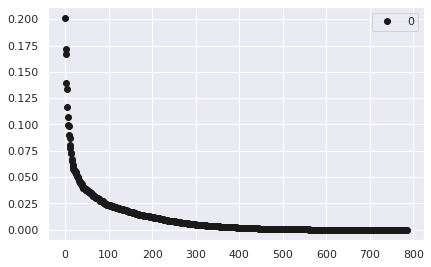

In [475]:
# plot dimensional error
pd.read_csv(DFILEc,sep=' ',header=None).transpose().plot(style='ko')

In [476]:
# get embedding matrix
Ec=pd.read_csv(EFILEc,sep=' ',header=None).dropna(axis=1).transpose()
Ec.columns=['x'+str(i) for i in Ec.columns]
Ec.to_csv(PREF+'Eb1c.csv')

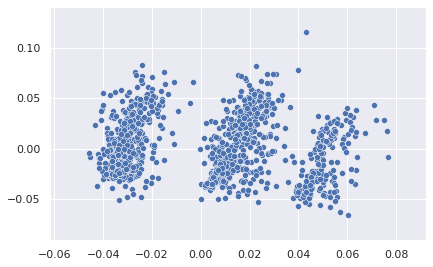

In [477]:
Efc=pd.read_csv(EFILEc,sep=' ',header=None).dropna(axis=1).transpose()
Efc.columns=['x'+str(i) for i in Efc.columns]
xfc=Efc#.assign(IF=dx.ido)

pcac = PCA(n_components=2).fit(xfc)
efc=pca.fit_transform(xfc)

pd.DataFrame(efc).to_csv(PCAEFILEc,header=None,index=None)

sns.scatterplot(x=efc[:,0],y=efc[:,1]);


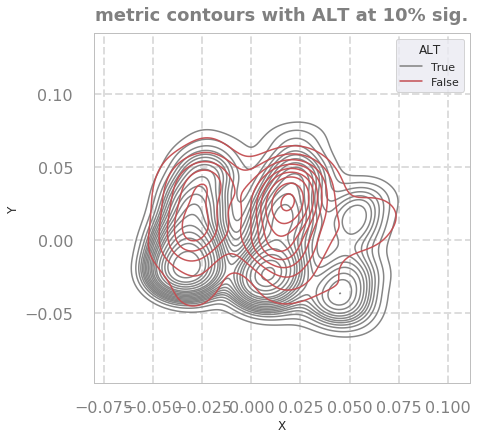

In [478]:
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

pf=pd.DataFrame(efc,columns=['X','Y']).assign(ido=cf.mdiss)
pf['ALT']=(pf.ido>threshold_p1)
pf['ALT']=[varname(x) for x in pf['ALT']]
ax=sns.kdeplot(x='X',y='Y',fill=False,data=pf,alpha=.95,lw=2,levels=20,thresh=.05,hue='ALT',palette=['.5','r'],fontsize=16)

ax.set_title('metric contours with ALT at 10% sig.',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig(OUTPUTDIR+'dxcontour_diss_p10_corr'+'.png',dpi=600,bbox_inches='tight',transparent=True)